## PURPOSE OF THE NOTEBOOK
The aim of this notebook is to define vessels present in the GB sections and define size, structure and composition of them

# Import all libraries & functions needed

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
import scanpy as sc
import os 
import seaborn as sns
import networkx as nx
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm
import scipy.stats as scpst

In [39]:
def connected_components(neighbors):
    seen = set()
    def component(node):
        nodes = set([node])
        while nodes:
            node = nodes.pop()
            seen.add(node)
            nodes |= neighbors[node] - seen
            yield node
    for node in neighbors:
        if node not in seen:
            yield component(node)
def getRoots(aNeigh):
    def findRoot(aNode,aRoot):
        while aNode != aRoot[aNode][0]:
            aNode = aRoot[aNode][0]
        return (aNode,aRoot[aNode][1])
    myRoot = {} 
    for myNode in aNeigh.keys():
        myRoot[myNode] = (myNode,0)  
    for myI in aNeigh: 
        for myJ in aNeigh[myI]: 
            try:
                (myRoot_myI,myDepthMyI) = findRoot(myI,myRoot) 
                (myRoot_myJ,myDepthMyJ) = findRoot(myJ,myRoot) 
                if myRoot_myI != myRoot_myJ: 
                    myMin = myRoot_myI
                    myMax = myRoot_myJ 
                    if  myDepthMyI > myDepthMyJ: 
                        myMin = myRoot_myJ
                        myMax = myRoot_myI
                    myRoot[myMax] = (myMax,max(myRoot[myMin][1]+1,myRoot[myMax][1]))
                    myRoot[myMin] = (myRoot[myMax][0],-1) 
            except:
                sss=2
    myToRet = {}
    for myI in aNeigh: 
        if myRoot[myI][0] == myI:
            myToRet[myI] = []
    for myI in aNeigh: 
        myToRet[findRoot(myI,myRoot)[0]].append(myI) 
    return myToRet  

In [43]:
adatall=sc.read('/mnt/f/ISS/adata_baysor/adata_16samples_clustered_log_annotated_curated_notln_adata4_301023_with_colors.h5ad')

In [44]:
adata=adatall
adata.obsm["spatial"]=np.array([adata.obs.x,adata.obs.y,adata.obs.y]).transpose().astype('float64')

In [47]:
list(adata.obs['celltype_annotated_general'].unique())

['Nan_Doublets',
 'Ciliated',
 'Suprabasal',
 'Monocytes',
 'Myoepithelial',
 'Endothelial other',
 'Mast',
 'Deuterosomal',
 'Secretory',
 'Mucous',
 'Capillary',
 'Smooth muscle',
 'Squamous',
 'Epithelial other',
 'SMG intermediate',
 'Venous',
 'T/NK',
 'AT2',
 'Serous',
 'T lymphocytes',
 'Pericytes',
 'B plasma',
 'AT1',
 'Myofibroblasts',
 'Fibroblasts other',
 'Neuroendocrine',
 'Fibroblasts adventitial',
 'Lymphatic endothelial',
 'Basal',
 'Macrophages',
 'DC',
 'B lymphocytes',
 'Ionocytes',
 'Rare',
 'Aerocytes',
 'NK',
 'Tuft']

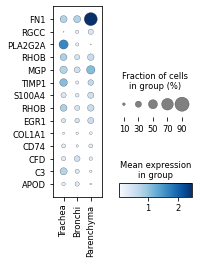

In [49]:
adata_fib=adata[adata.obs['celltype_annotated_general'].isin(['Fibroblasts adventitial','Fibroblasts other'])]
dicti={'LNG2':'Trachea', 'LNG3':'Bronchi', 'LNG5':'Parenchyma','LNG1':'Parenchyma','LNG6':'Parenchyma'}
adata_fib.obs['location']=list(adata_fib.obs['region'].map(dicti))
cats=['Trachea','Bronchi','Parenchyma']
geness=['FN1','RGCC','PLA2G2A','RHOB','MGP','TIMP1',
                        'S100A4','RHOB','EGR1','COL1A1','CD74',
                        'CFD','C3','APOD']
sc.pl.dotplot(adata_fib,geness,groupby='location',categories_order=cats,figsize=(2.5,3.5),save='dotplot_fibroblasts.pdf',swap_axes=True,cmap='Blues')

In [71]:
adata_fib=adata[adata.obs['celltype_annotated_general'].isin(['Fibroblast general'])]

In [ ]:
dicti={'LNG2':'Trachea', 'LNG3':'Bronchi', 'LNG5':'Parenchyma','LNG1':'Parenchyma','LNG6':'Parenchyma'}
adata_fib.obs['location']=list(adata_fib.obs['region'].map(dicti))
cats=['Trachea','Bronchi','Parenchyma']
geness=['FN1','RGCC','PLA2G2A','RHOB','MGP','TIMP1',
                        'S100A4','RHOB','EGR1','COL1A1','CD74',
                        'CFD','C3','APOD']
sc.pl.dotplot(adata_fib,geness,groupby='location',categories_order=cats,figsize=(6,1),save='dotplot_general.pdf')

In [ ]:
dicti={'LNG2':'Trachea', 'LNG3':'Bronchi', 'LNG5':'Parenchyma','LNG1':'Parenchyma','LNG6':'Parenchyma'}
adata_fib.obs['location']=list(adata_fib.obs['region'].map(dicti))
adata_fib.obs['donor']=[e[:-5] for e in adata_fib.obs['sample']]
adata_fib.obs['suit']=adata_fib.obs['location'].astype(str)+'_'+adata_fib.obs['donor'].astype(str)
cats=['Trachea_588B','Trachea_583B', 'Trachea_689C', 'Trachea_640C',
      'Bronchi_689C', 'Bronchi_640C', 'Bronchi_583B','Bronchi_588B1',
    'Parenchyma_588B',  'Parenchyma_583B', 'Parenchyma_689C',
      'Parenchyma_588B2', 'Parenchyma_640C',
      ]
geness=['FN1','RGCC','PLA2G2A','RHOB','MGP','TIMP1',
                        'S100A4','RHOB','EGR1','COL1A1','CD74',
                        'CFD','C3','APOD']
sc.pl.dotplot(adata_fib,geness,groupby='suit',categories_order=cats,figsize=(6,3),save='dotplot_general_by_donor.pdf')

In [41]:
sc.pp.neighbors(adata_fib,n_pcs=0)
sc.tl.umap(adata_fib)

In [52]:
adata_fib['loca']

AnnData object with n_obs × n_vars = 48083 × 159
    obs: 'cell', 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'sample', 'region', 'n_genes', 'n_counts', 'counts_markers', 'leiden2', 'reference', 'old_annotation', 'annotation_3', 'annotation_2', 'annotation_1', 'leiden', 'previous_annotation', 'celltype_annotated', 'celltype_annotated_epi', 'ID', 'celltype_annotated_refined', 'celltype_annotated_general', 'cell_class', 'location'
    uns: 'celltype_annotated_colors', 'celltype_annotated_epi_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

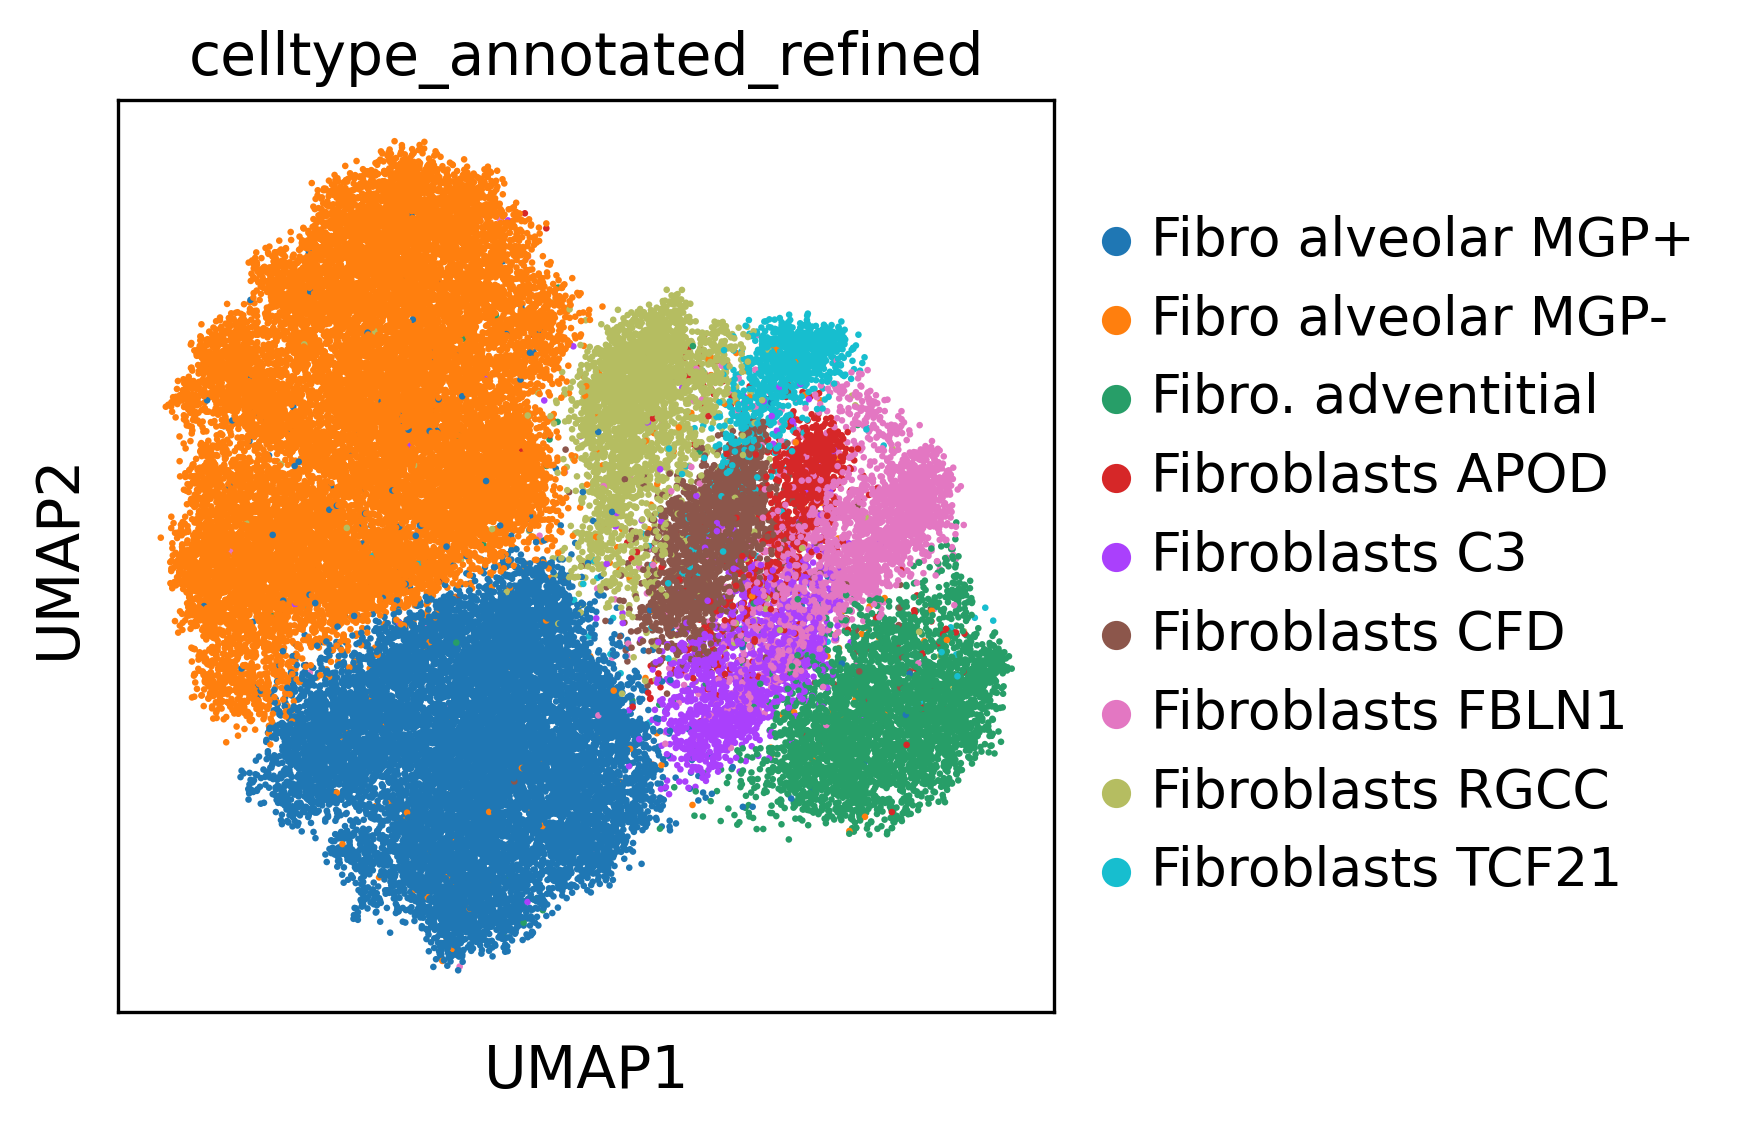

In [61]:
sc.set_figure_params(scanpy=True, dpi=150)
sc.pl.umap(adata_fib,color='celltype_annotated_refined',s=10)

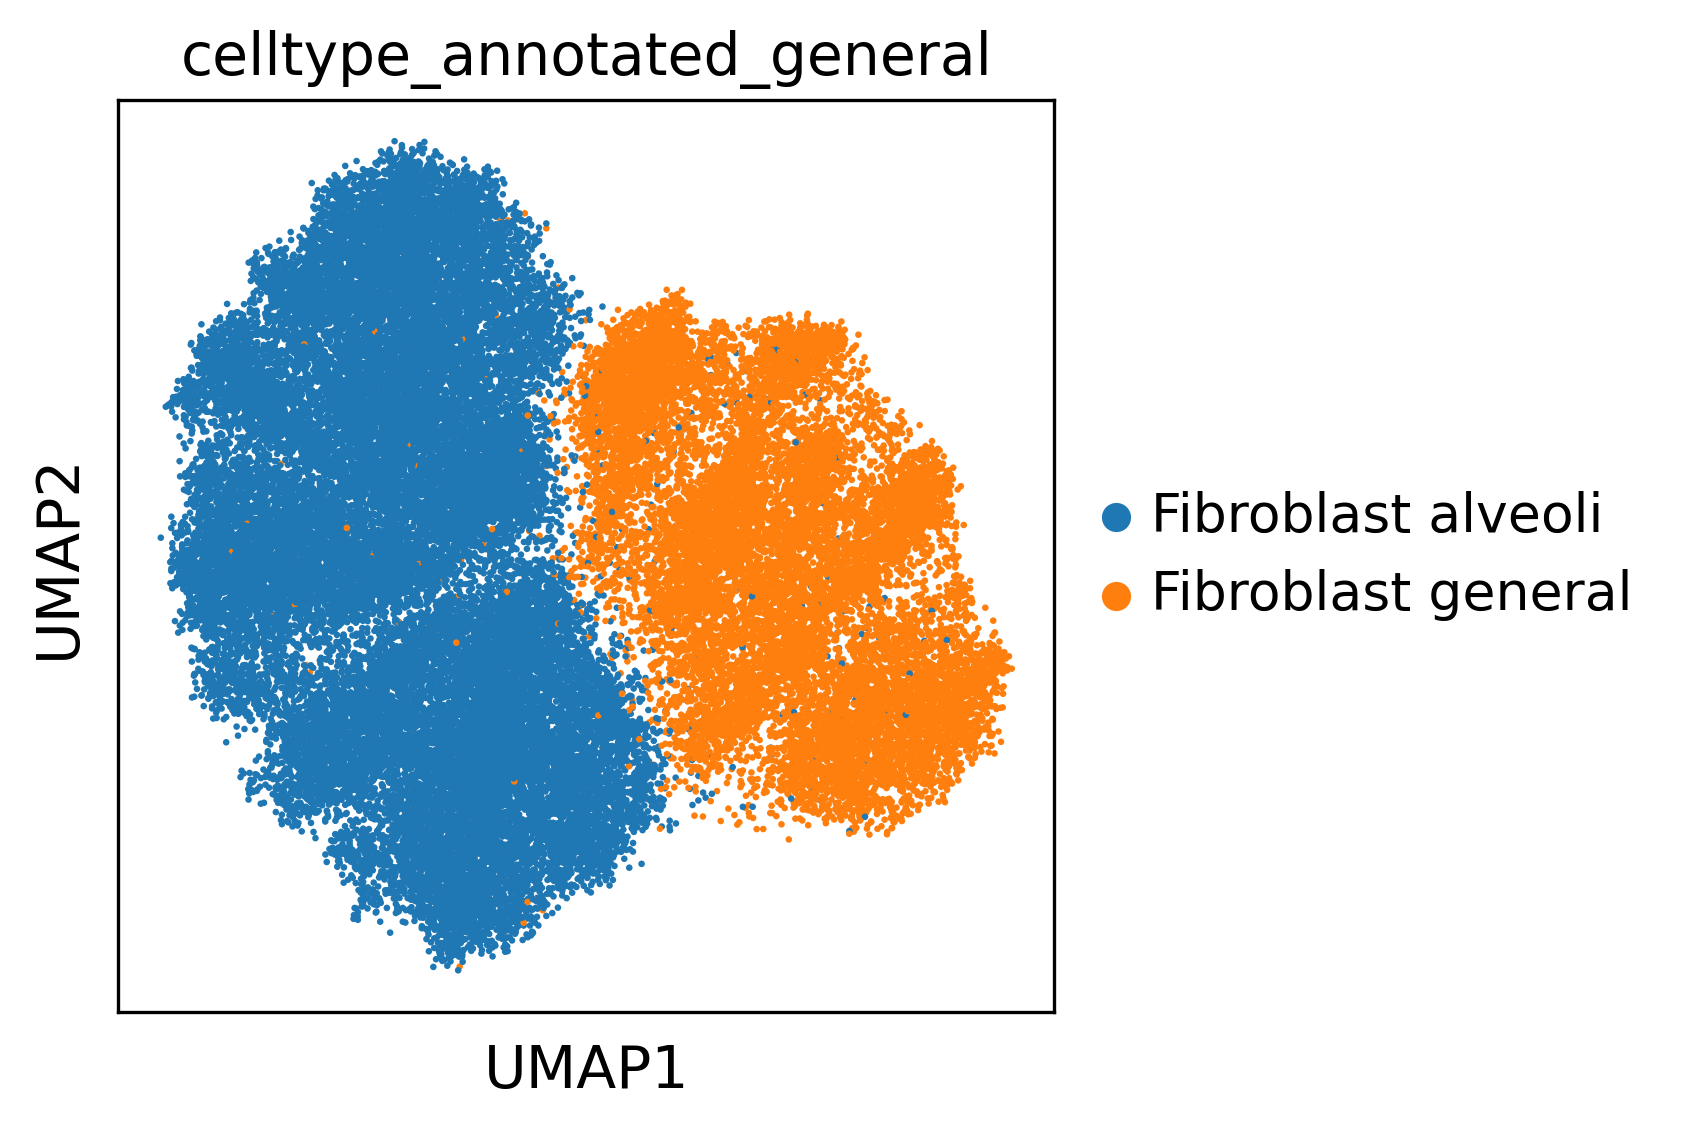

In [57]:
sc.set_figure_params(scanpy=True, dpi=150)
sc.pl.umap(adata_fib,color='celltype_annotated_general',s=10)

In [ ]:
sc.pl.umap(adata_fib,color='location',s=10)

In [ ]:
geness=['FN1','RGCC','PLA2G2A','RHOB','MGP','TIMP1',
                        'S100A4','RHOB','EGR1','COL1A1','CD74',
                        'CFD','C3','APOD']
sc.pl.umap(adata_fib,color=geness,ncols=2,vmax='p98')

# Regional expression endothelial

In [50]:
list(adatall.obs['celltype_annotated_general'].unique())

['Nan_Doublets',
 'Ciliated',
 'Suprabasal',
 'Monocytes',
 'Myoepithelial',
 'Endothelial other',
 'Mast',
 'Deuterosomal',
 'Secretory',
 'Mucous',
 'Capillary',
 'Smooth muscle',
 'Squamous',
 'Epithelial other',
 'SMG intermediate',
 'Venous',
 'T/NK',
 'AT2',
 'Serous',
 'T lymphocytes',
 'Pericytes',
 'B plasma',
 'AT1',
 'Myofibroblasts',
 'Fibroblasts other',
 'Neuroendocrine',
 'Fibroblasts adventitial',
 'Lymphatic endothelial',
 'Basal',
 'Macrophages',
 'DC',
 'B lymphocytes',
 'Ionocytes',
 'Rare',
 'Aerocytes',
 'NK',
 'Tuft']

In [58]:
sc.set_figure_params(figsize=(9,8),dpi=300)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [59]:
gg2=['CD74','CLDN5','FCN3','IFI27','IFITM2','LYZ','MYL9','RAMP2','RHOB','ZFP36']

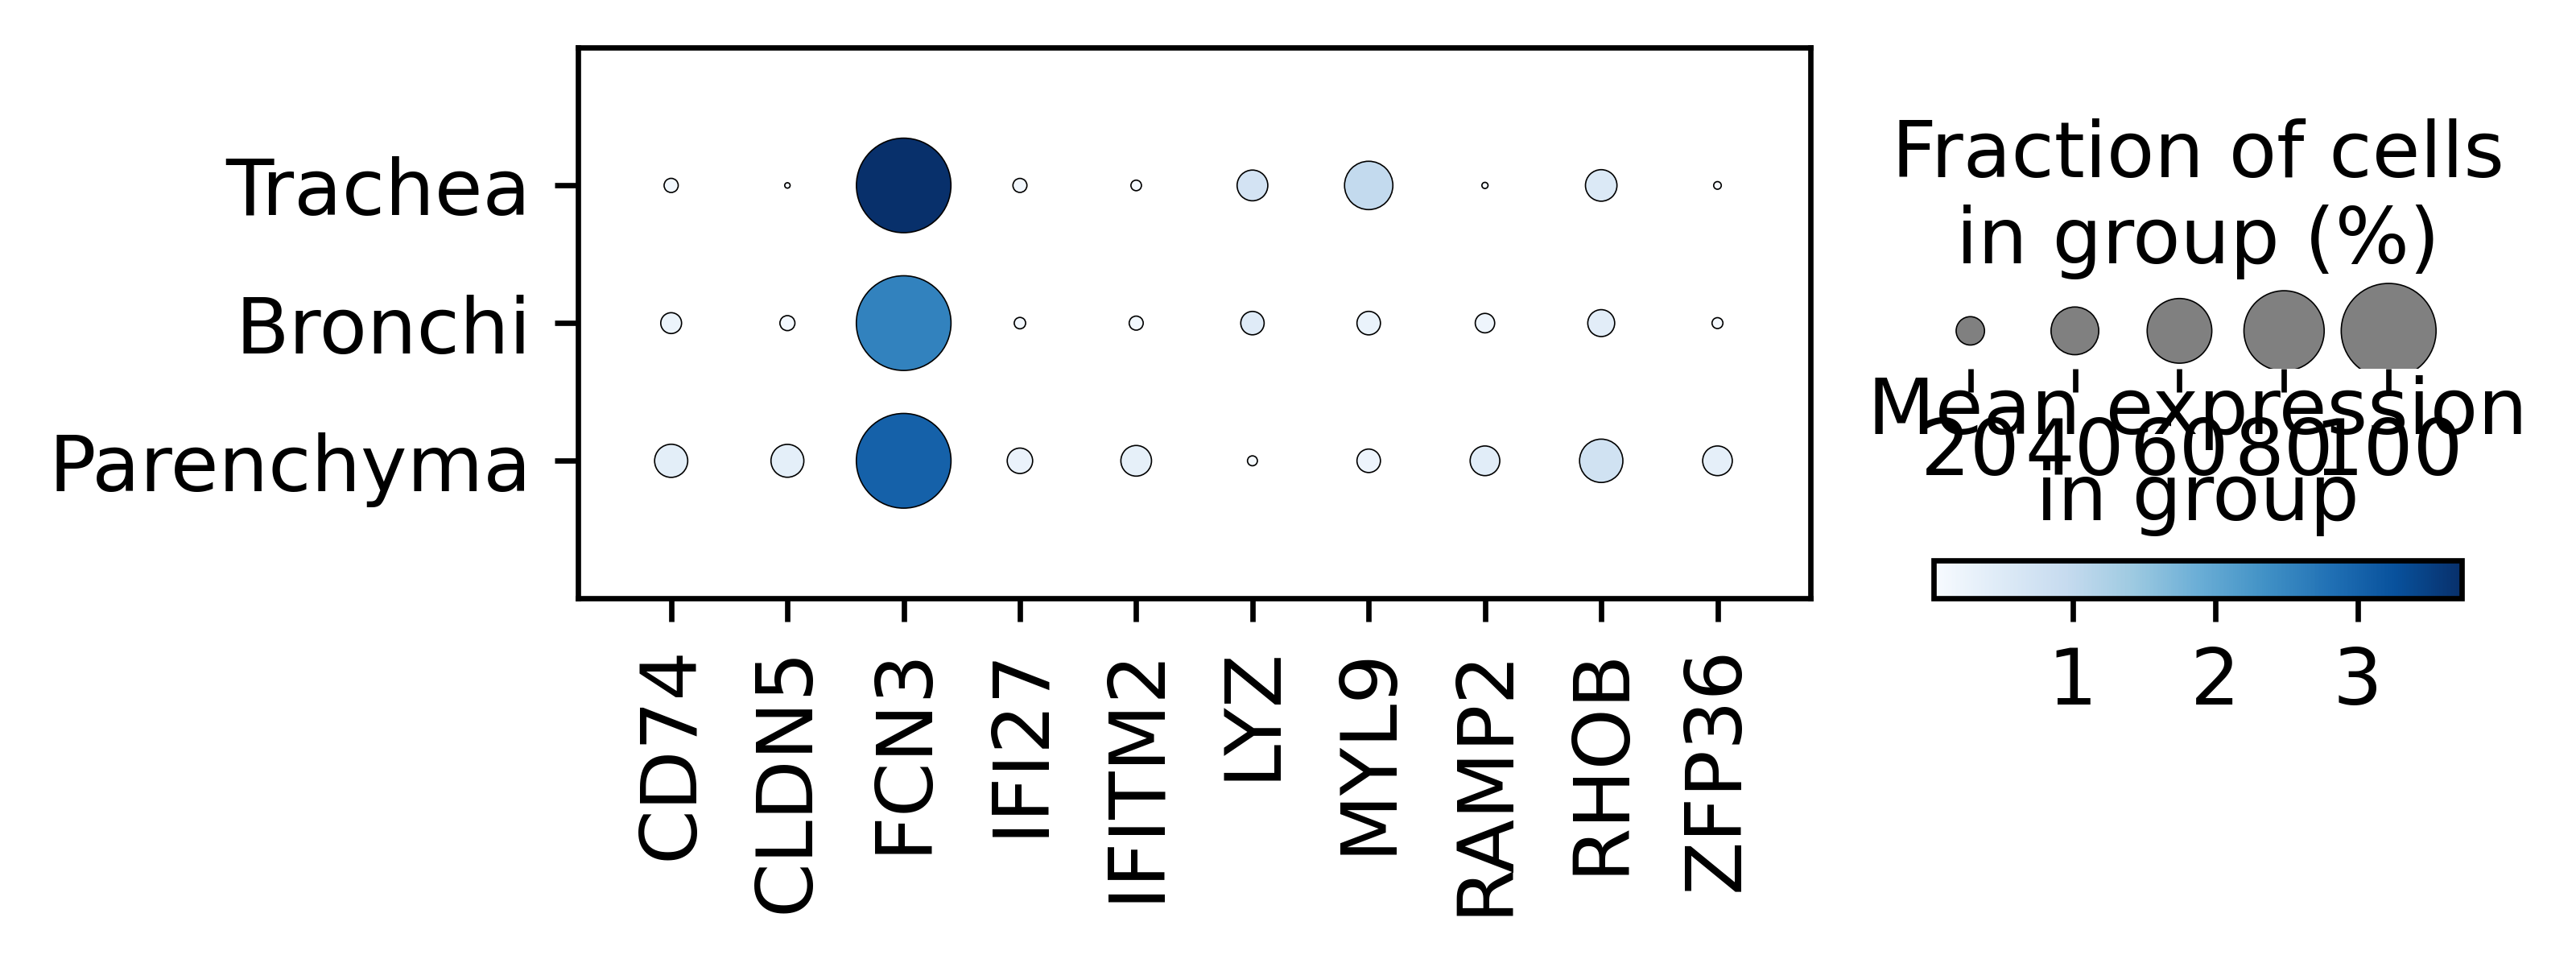

In [60]:
adata_fib=adata[adata.obs['celltype_annotated_general'].isin(['Arterial','Capillary','Lymphatic endothelium'])]
dicti={'LNG2':'Trachea', 'LNG3':'Bronchi', 'LNG5':'Parenchyma','LNG1':'Parenchyma','LNG6':'Parenchyma'}
adata_fib.obs['location']=list(adata_fib.obs['region'].map(dicti))
cats=['Trachea','Bronchi','Parenchyma']
sc.pl.dotplot(adata_fib,gg2,groupby='location',categories_order=cats,figsize=(5,1.5),cmap='Blues',save='endothleial_dotplot_regional.pdf')

In [74]:
gg3=['C1QC','C3','CD74','FN1','FKBP11','HDC','HLA-DPB1','HLA-DRA','JCHAIN','S100A8','S100A4','SLPI']

In [75]:
sel2=['Monocytes', 'Mast', 'T/NK', 'T lymphocytes', 'B plasma',
 'Macrophages', 'DC', 'B lymphocytes', 'NK', 'Tuft']

In [ ]:
adata_fib=adata[adata.obs['celltype_annotated_general'].isin(sel2)]
dicti={'LNG2':'Trachea', 'LNG3':'Bronchi', 'LNG5':'Parenchyma','LNG1':'Parenchyma','LNG6':'Parenchyma'}
adata_fib.obs['location']=list(adata_fib.obs['region'].map(dicti))
cats=['Trachea','Bronchi','Parenchyma']
sc.pl.dotplot(adata_fib,gg3,groupby='location',categories_order=cats,figsize=(2.8,4),swap_axes=True,cmap='Blues',save='immune_dotplot_regional.pdf')